## 21 - Conflict
>Map a conflict. Political, territorial, or social—there are conflicts all around us. Map boundaries, tension points, or the outcomes of conflicts. ⚔️🛑

In [ ]:
import mapping_funcs as mf
import osmnx as ox
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray as rio
from shapely import box
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patheffects as path_effects

In [2]:
aoi = Polygon([
            [
              -63.475562652796924,
              -9.630399179417921
            ],
            [
              -63.475562652796924,
              -9.811909937172459
            ],
            [
              -63.1891950257334,
              -9.811909937172459
            ],
            [
              -63.1891950257334,
              -9.630399179417921
            ],
            [
              -63.475562652796924,
              -9.630399179417921
            ]
          ])

In [5]:
imgs = mf.SatelliteImage(aoi,
                         collection=['sentinel-2-l2a'],
                         datetime='2010-01-01/2025-01-01',
                         cloud=15)

found 149 items
149 contain aoi


In [9]:
first = imgs.clipd_containing_stack[0,:,:,:].sel(band=['B08', 'B04'])
ndvi1 = (first[0,:,:] - first[1,:,:]) / (first[0,:,:] + first[1,:,:])

In [18]:
last = imgs.clipd_containing_stack[-1,:,:,:].sel(band=['B08', 'B04'])
ndvi2 = (last[0,:,:] - last[1,:,:]) / (last[0,:,:] + last[1,:,:])

In [ ]:
ndvi1 = ndvi1.compute()
ndvi2 = ndvi2.compute()

In [24]:
time_delta = (last.time - first.time) / pd.Timedelta('365.25D')

In [128]:
print(f'{last.time.data}\n{first.time.data}\n{time_delta.data}')

2024-10-26T14:27:11.024000000
2015-08-25T14:33:16.030000000
9.171788570550358


In [61]:
px, py = box(*ndvi1.rio.bounds()).centroid.xy

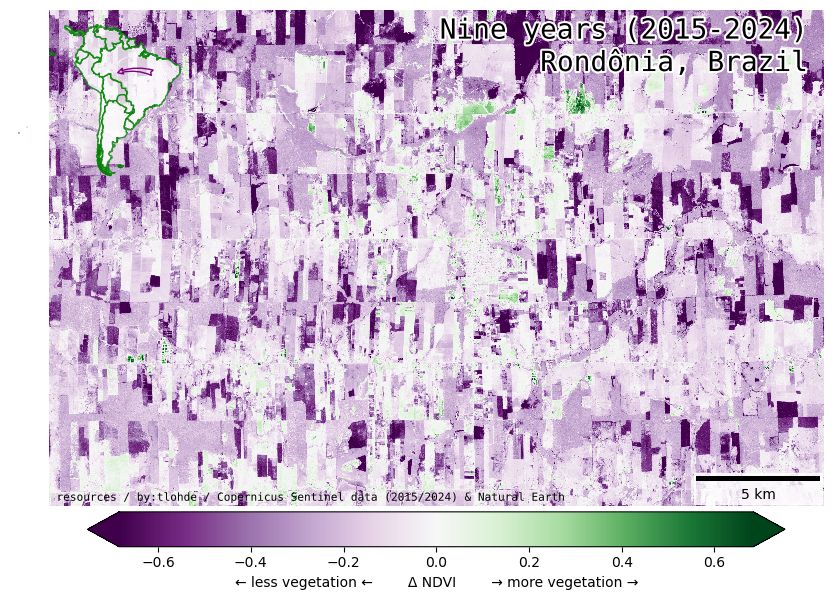

In [ ]:
fig, ax = plt.subplots(figsize=[10,8],
                       subplot_kw={'aspect':'equal'})

(ndvi2 - ndvi1).plot(ax=ax,
                     cmap='PRGn',
                     robust=True,
                     cbar_kwargs={'orientation':'horizontal',
                                  'label':'← less vegetation ←        Δ NDVI        → more vegetation →',
                                  'pad':0.01,
                                  'shrink':0.9})

ax.set_title(None)
ax.set_axis_off()

inset = ax.inset_axes((-0.05, 0.65, 0.25, 0.35), aspect='equal')

(gpd.read_file('../../ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp',
               where="continent in ('North America', 'South America')"
               ).cx[-90:-40,-80:10]).to_crs(ndvi1.rio.crs).plot(ax=inset, fc='w', ec='green',
                                                                alpha=0.8)

inset.set_axis_off()
inset.annotate('',
               xy=(px[0],py[0]),
               xytext=(px[0]+2_000_000, py[0]-2_000),
               arrowprops=dict(arrowstyle="fancy",
                               fc='none', ec='purple',
                               connectionstyle="arc3, rad=0.2",
                               ))

ax.add_artist(ScaleBar(1, location='lower right', box_alpha=0.8))

ax.annotate('resources / by:tlohde / Copernicus Sentinel data (2015/2024) & Natural Earth',
            xy=(0.01, 0.01),
            xycoords='axes fraction',
            fontsize=8,
            font='DejaVu Sans Mono',
            path_effects=[path_effects.withSimplePatchShadow(offset=(1,-1),
                                                             shadow_rgbFace='w'),
                          ])

ax.set_title('Nine years (2015-2024)\nRondônia, Brazil',
             x=0.98, y=0.86,
             ha='right',
             font='DejaVu Sans Mono',
             fontsize=20,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                           path_effects.Normal()
                          ])

fig.savefig('day21.png', dpi=300, bbox_inches='tight')